# Matrix Factorization 1

* 최근 추천 시스템의 근간인 Matrix Factoization 모델에 대해서 알아 봅니다.

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# MovieLens 100K를 데이터셋을 불러옵니다.
df_ratings = pd.read_csv('dataset/ratings_100k.csv')
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv('dataset/users_100k.csv', index_col='user id')
df_movie = pd.read_csv('dataset/movies_100k.csv', index_col='movie id')

## 상호작용(Iteraction)

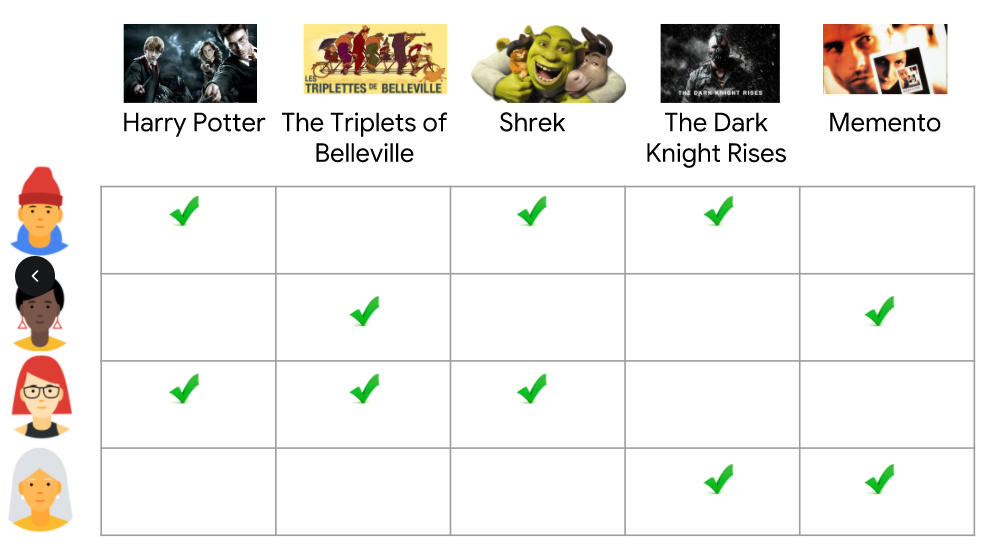

**개인취향**

**Iteraction Matrix**

예제) MovieLen 100K 데이터셋에서 Interaction Matrix를 만들어봅니다.

평졈 호불호가 분명한 영화 몇 개와 사용자 몇 명을 뽑아 상호 작용 행렬의 예를 들어 봅니다.

In [9]:
# 1990년대 유명하고 제목이 짧은 영화 몇 편 뽑습니다.
item_index = [1, 226, 96, 402, 69, 29]
df_movie.loc[df_movie.index.isin(item_index)]

,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29,Batman Forever (1995),01-Jan-1995,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
69,Forrest Gump (1994),01-Jan-1994,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
96,Terminator 2: Judgment Day (1991),01-Jan-1991,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
226,Die Hard 2 (1990),01-Jan-1990,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
402,Ghost (1990),01-Jan-1990,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


In [10]:
# 평점의 표준편차가 1이 넘고 선정한 영화를 3건 넘게 시청한 사용자 중 평점순으로 10명을 뽑습니다.
df_user.loc[
    df_ratings.groupby('user id').filter(
        lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3
    )['user id'].value_counts().head(10).index
]

,age,gender,occupation,zip code
user id,,,,
405,22,F,healthcare,10019
13,47,M,educator,29206
276,21,M,student,95064
416,20,F,student,92626
303,19,M,student,14853
279,33,M,programmer,85251
846,27,M,lawyer,47130
7,57,M,administrator,91344
94,26,M,student,71457


In [11]:
# 위에서 선정한 영화를 적어도 3편 넘게 본 10명의 사용자를 뽑습니다.
user_index = df_ratings.groupby('user id').filter(
    lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3
)['user id'].value_counts().head(10).index

# 피벗을 통해 사용자 × 영화로 구성된 상호작용행렬을 만듭니다.
df_interaction = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
].join(df_movie['movie title'], on='item id')\
.join(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1).rename('user'), on='user id')\
.pivot(index='user',  columns='movie title', values='rating').sort_index().sort_index(axis=1)
df_interaction

movie title,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user,,,,,,
19/M/student,2.0,4.0,5.0,4.0,5.0,5.0
20/F/student,2.0,4.0,4.0,5.0,4.0,5.0
21/M/student,3.0,4.0,4.0,3.0,5.0,5.0
22/F/healthcare,4.0,2.0,4.0,3.0,3.0,NaN
23/M/programmer,2.0,3.0,4.0,NaN,4.0,4.0
26/M/student,2.0,2.0,3.0,4.0,3.0,4.0
27/M/lawyer,2.0,4.0,5.0,NaN,4.0,NaN
33/M/programmer,2.0,4.0,NaN,NaN,4.0,3.0
47/M/educator,2.0,4.0,4.0,4.0,4.0,3.0


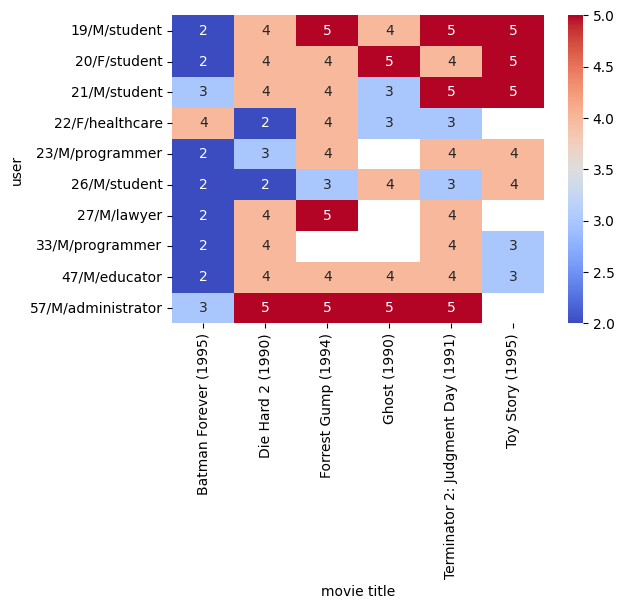

In [12]:
plt.figure(figsize=(6, 4))
cmap_coolwarm = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(df_interaction, cmap=cmap_coolwarm, annot=True)
plt.show()

# Matrix Factorization

상호작용을 모델링하기 위한 모델

> Sparsity가 큰 Sparse Matrix입니다.

> 크기는 User와 Item의 수의 곱입니다. 

$N_{user}×N_{item}$의 상호작용 행렬(Matrix)을 

$N_{user}×Rank$사용자 행렬과 $N_{item}×Rank$아이템 행렬 두 개의 행렬곱으로 분해하는 모델입니다.

$Interaction = User × Item^T$

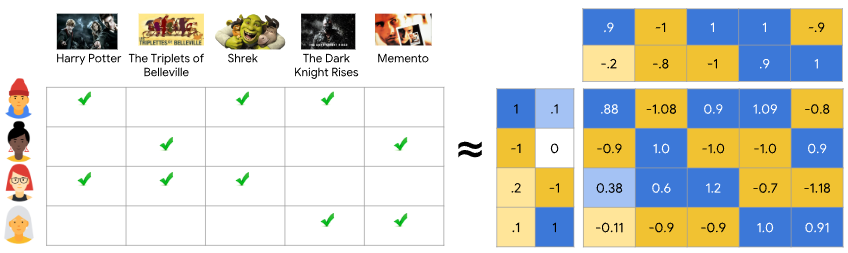


사용자 행렬: $N_{user}×Rank$ - 사용자 임베딩

아이템 행렬: $N_{item}×Rank$ - 아이템 임베딩

## 학습방법

### ALS(Alternating Least Square):

Loss: Mean Squared Error 

사용자의 평점은 아이템(영화)의 임베딩이 입력인 선형회귀모델로 나타냅니다, 이 때 사용자의 임베딩은 선형회귀모델의 계수가 됩니다.

아이템(영화)의 평점은 사용자의 임베딩이 입력인 선형회귀모델로 나타냅니다, 이 때 아이템(영화)의 임베딩은 선형회귀모델의 계수가 됩니다.

사용자의 임베딩은 아이템(영화)의 임베딩을 입력인 선형회귀모델의 학습을 통해 구합니다.

아이템(영화)의 임베딩은 사용자의 임베딩를 입력인 선형회귀모델의 학습을 통해 구합니다.

사용자 임베딩과 아이템 임베딩을 사용자 / 아이템 번갈아 가면서 

학습시킵니다.

(1) 사용자 / 아이템 임베딩 초기화

(2-1) 사용자 임베딩 학습을 통해 업데이트

(2-2) 아이템 임베딩 학습을 통해 업데이트

(3) (2)과정 사용자의 임베딩과 아이템의 임베딩이 반복

In [13]:
# ALS를 Demo를 위한 위에서 보인 케이스만을 취합니다.
df_ratings_toy = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
]
df_ratings_toy

,user id,item id,rating,date
233,303,69,5,1997-11-14 00:32:22
1381,279,96,4,1997-09-26 21:50:06
1899,276,226,4,1997-09-20 21:55:20
3190,13,226,4,1997-12-17 22:27:31
4113,13,29,2,1997-12-17 22:30:33
5118,94,402,4,1998-04-04 20:54:21
7036,7,226,5,1998-03-31 14:13:34
8032,303,96,5,1997-11-14 00:20:30
8186,279,226,4,1997-11-30 00:34:33
8890,276,69,4,1997-09-20 21:29:56


1. 사용자 / 아이템 임베딩 초기화

$(0, \frac{1}{\sqrt{Rank}})$ 사이의 임의의 실수로 초기화합니다.

In [14]:
# 사용자와 아이템 행렬의 랭크를 3으로 합니다.
Rank = 3
# 동일한 결과를 얻기 위해 랜덤 시드값을 지정합니다.
np.random.seed(123)
# (0, 1/(Rank ** 0.5)) 사이의 난수를 사용자와 아이템의 임베딩 초기값으로 설정합니다.
df_user_emb = pd.DataFrame((np.random.random(size=(len(user_index), Rank))) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame((np.random.random(size=(len(item_index), Rank))) * 1 / np.sqrt(Rank), index=item_index)

2. 사용자 / 아이템 임베딩 학습

정규방정식을 이용하여 선형회귀모델을 학습시켜 계수를 구하여 임베딩을 업데이트 합니다.

$\hat{\beta} = (X^T X)^{-1} X^T y$

In [15]:
# 입력 Matrix와 대상 변수에 대한 선형회귀 모델의 계수를 반환합니다.
def lr_coef(X, y):
    return np.dot(
        np.linalg.inv(np.dot(X.T, X)),
        np.dot(X.T, y)
    )

In [16]:
# 2-1 아이템 임베딩 학습

# 사용자 ID에 사용자 임베딩을 매핑시켜서 아이템 임베딩을 학습하기 위한 입력 변수를 만듭니다.
X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])

# OLS를 이용하여 아이템별 회귀계수를 구합니다.
df_item_emb_next = X_user.groupby(df_ratings_toy['item id']).apply(
    lambda x: pd.Series(lr_coef(x, df_ratings_toy.loc[x.index, 'rating'].values))
)
# 변경의 정도를 파악하기 위해 업데이트한 아이템 임베딩과 이전 임베딩 간의 차이의 제곱을 구합니다.
item_emb_diff = np.sum(np.sum(np.square(df_item_emb - df_item_emb_next), axis=0), axis=0)
# 업데이트 합니다.
df_item_emb = df_item_emb_next
df_item_emb

,0,1,2
item id,,,
1,6.593251,-5.205982,11.547203
29,5.522431,-1.471823,2.790506
69,5.779319,-2.980770,9.995943
96,6.702058,-3.136439,8.957213
226,4.665782,-0.624460,7.610579
402,3.374478,-2.270883,11.992309


In [17]:
item_emb_diff

728.5732918746362

In [18]:
# 2-2 사용자 임베딩 학습

# 아이템 ID에 아이템 임베딩을 매핑시켜서 사용자 임베딩을 학습하기 위한 입력 변수를 만듭니다.
X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])

df_user_emb_next = X_item.groupby(df_ratings_toy['user id']).apply(
    lambda x: pd.Series(lr_coef(x,  df_ratings_toy.loc[x.index, 'rating'].values))
)

user_emb_diff = ((df_user_emb - df_user_emb_next) ** 2).sum().sum()
df_user_emb = df_user_emb_next
df_user_emb

,0,1,2
user id,,,
7,0.516061,0.634194,0.392124
13,0.393520,0.678048,0.356878
94,0.099894,-0.136134,0.233914
276,0.574649,0.098999,0.131147
279,0.384026,0.682809,0.361387
303,0.353320,0.133474,0.298755
405,0.449600,-0.317001,0.013785
416,0.194407,0.213311,0.395661
682,0.276504,0.114749,0.256512


In [19]:
user_emb_diff

1.1871361153118554

In [20]:
emb_diff = item_emb_diff + user_emb_diff
emb_diff

729.7604279899481

3. 2의 과정을 반복

In [21]:
# 1~3을 종합
from sklearn.metrics import mean_squared_error

# Step 1
Rank = 3
np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3: 10회 반복
for epoch in range(10):
    # Step 2
    # 사용자 ID에 사용자 임베딩을 매핑시켜서 아이템 임베딩을 학습하기 위한 입력 변수를 만듭니다.
    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])

    #OLS를 이용하여 아이템별 회귀계수를 구합니다.
    df_item_emb_next = X_user.groupby(df_ratings_toy['item id']).apply(
        lambda x: pd.Series(np.dot(np.linalg.inv(np.dot(x.T, x) + np.eye(Rank)), np.dot(x.T, df_ratings_toy.loc[x.index, 'rating'].values)))
    )
    item_emb_diff = np.sum(np.square(df_item_emb - df_item_emb_next), axis=0)
    df_item_emb = df_item_emb_next

    # 사용자 임베딩 학습
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    df_user_emb_next = X_item.groupby(df_ratings_toy['user id']).apply(
        lambda x: pd.Series(np.dot(np.linalg.inv(np.dot(x.T, x) + np.eye(Rank)), np.dot(x.T, df_ratings_toy.loc[x.index, 'rating'].values)))
    )
    user_emb_diff = np.sum(np.square(df_user_emb - df_user_emb_next), axis=0)
    df_user_emb = df_user_emb_next
    
    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    emb_diff = np.sum(item_emb_diff + user_emb_diff, axis=0)
    print(epoch + 1, emb_diff, mse)

1 125.40152217129432 0.30311758075205275
2 7.44655441407117 0.16065514853358448
3 2.340753537732448 0.14465440818825825
4 1.112615350361393 0.14129914903184837
5 0.5985562638140101 0.13882291888655154
6 0.3474541717204749 0.13672707267582285
7 0.21429991842209503 0.13498097660085226
8 0.13794128102646688 0.13360029488939343
9 0.09041121906359151 0.13267896243750787
10 0.059408803768041085 0.13226639679743832


In [22]:
# Index에 MetaData를 가져옵니다.
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [23]:
df_user_emb

,0,1,2
user id,,,
57/M/administrator,0.963238,0.245983,1.537750
47/M/educator,0.563863,0.424624,1.232307
26/M/student,0.645884,-0.599708,1.073937
21/M/student,1.231208,0.441977,0.977778
33/M/programmer,0.683534,0.695800,0.980326
19/M/student,0.840252,0.301358,1.401665
22/F/healthcare,1.570758,-0.395488,0.465107
20/F/student,0.545415,-0.206599,1.592869
23/M/programmer,0.791941,0.089304,1.079374


In [24]:
df_item_emb

,0,1,2
item id,,,
Toy Story (1995),1.743834,-0.166699,2.257279
Batman Forever (1995),1.774870,-0.105870,0.705216
Forrest Gump (1994),1.775550,0.408621,2.126078
Terminator 2: Judgment Day (1991),1.612199,0.763062,2.165580
Die Hard 2 (1990),1.067193,1.036445,2.128819
Ghost (1990),1.077664,-0.329704,2.427278


In [25]:
# 사용자별 아이템에 대한 평점 예측을 합니다.
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

item id,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user id,,,,,,
19/M/student,2.447911,4.192944,4.595101,4.208382,4.620027,4.578974
20/F/student,2.113231,3.758864,4.270555,4.522226,4.171155,4.581102
21/M/student,2.827988,3.853534,4.445506,3.554446,4.439665,4.280463
22/F/healthcare,3.157763,2.256529,3.616209,2.952087,3.237819,3.854945
23/M/programmer,2.157329,3.235503,3.737455,3.443942,3.682380,3.802573
26/M/student,1.967210,2.353936,3.185021,3.500516,2.909376,3.650461
27/M/lawyer,2.224274,3.864114,4.208966,3.842934,4.242883,4.179688
33/M/programmer,1.830863,3.537558,3.582218,2.886736,3.755906,3.288850
47/M/educator,1.824872,3.665209,3.794659,3.458806,3.901733,3.694159


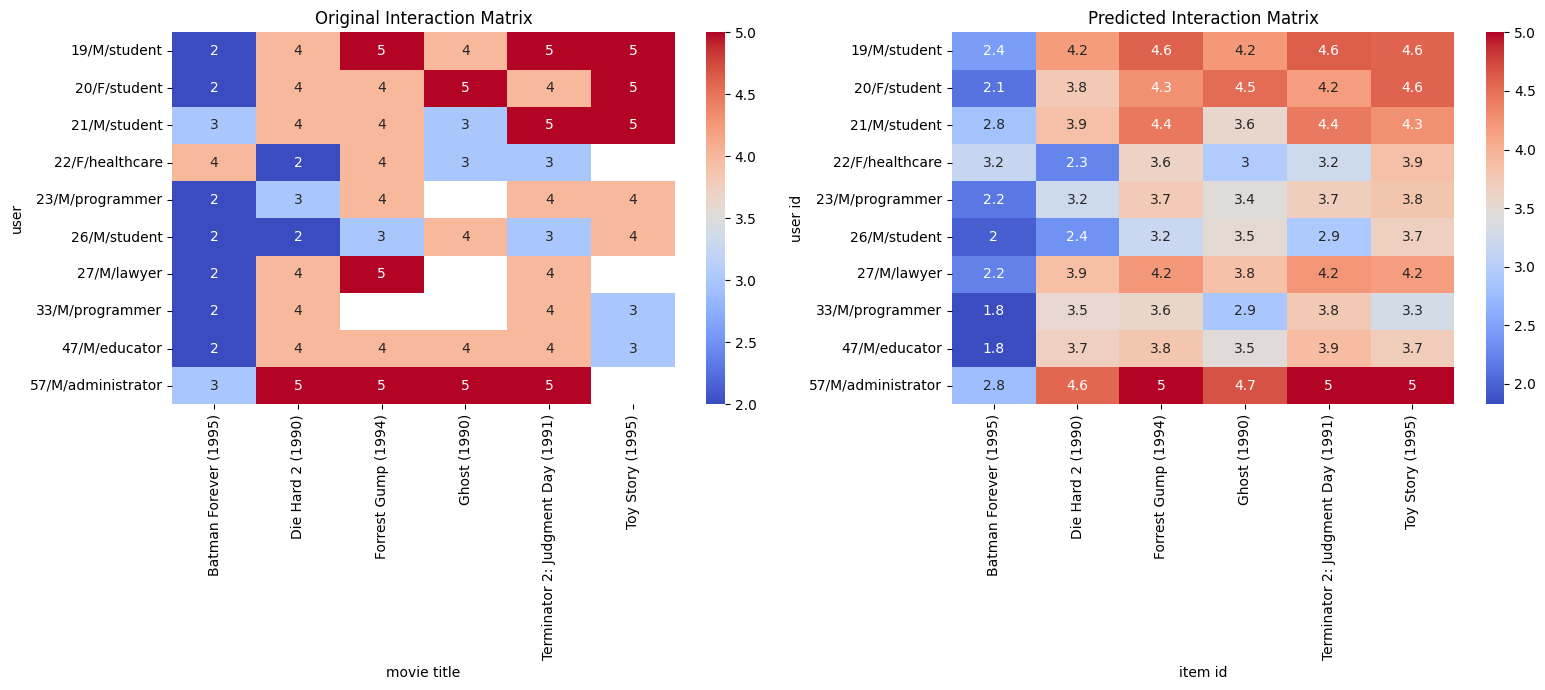

In [26]:
# 원래 상호작용행렬과 예측한 상호작용행렬을 Heat을 사용하여 표시합니다.
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(
    df_interaction,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[0]
)
axes[0].set_title('Original Interaction Matrix')

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True, cmap=cmap_coolwarm,
    ax=axes[1]
)
axes[1].set_title('Predicted Interaction Matrix')

plt.tight_layout()
plt.show()

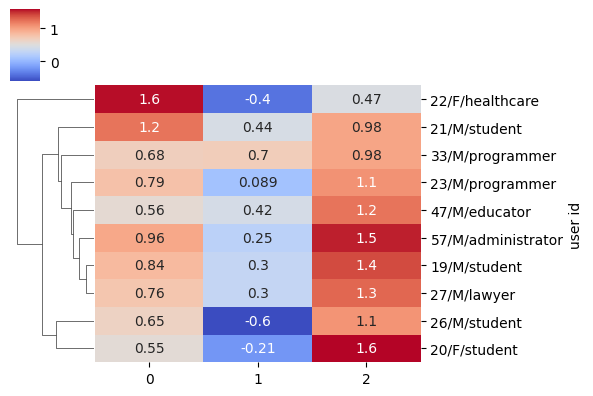

In [27]:
sns.clustermap(
    df_user_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(6,4),
)
plt.show()

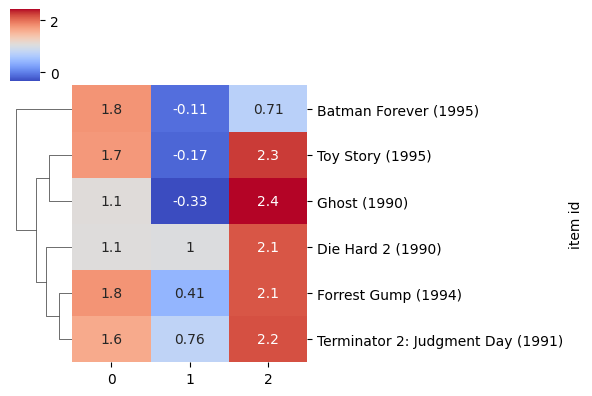

In [28]:
sns.clustermap(
    df_item_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(6, 4),
)
plt.show()

### 경사하강법(Gradient Descent)

$\hat{y} = User × Item^T$

$Loss = \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)^2}$

$\frac{dLoss}{dUser_u} = -\frac{2}{n_u}\sum_{j∈u's Rating}{\left(y_{j} - \hat{y}_{j}\right)Item_j}$

$\frac{dLoss}{dItem_i} = -\frac{2}{n_i}\sum_{j∈i's Rating}{\left(y_{j} - \hat{y}_{j}\right)User_j}$

(1) 사용자 / 아이템 임베딩 초기화

(2-1) 경사 계산

(2-2) 임베딩 업데이트

(3) (2)과정 반복

In [29]:
# Step 1: 임베딩을 초기화 합니다.
Rank = 3 # 랭크는 3으로 합니다.
learning_rate = 0.1 # 학습율은 0.1로 합니다.

np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

In [30]:
# Step 2-1: 경사(기울기)를 계산합니다.

X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
y_hat = (X_user * X_item).sum(axis=1)
err = df_ratings_toy['rating'] - y_hat

X_user_g = -X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
X_item_g = -X_user.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))

In [31]:
# Step 2-2: 계산한 경사로 임베딩을 업데이트 합니다.

df_user_emb -= X_user_g * learning_rate
df_item_emb -= X_item_g * learning_rate

* 1~3 과정을 통합하여 루틴을 구성합니다.

In [32]:
# Step 1
Rank = 3
learning_rate = 0.1

np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3
for epoch in range(10):
    # Step 2-1

    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    y_hat = (X_user * X_item).sum(axis=1)
    err = df_ratings_toy['rating'] - y_hat

    X_user_g = -X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    X_item_g = -X_user.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    
    # Step 2-2

    df_user_emb -= X_user_g * learning_rate
    df_item_emb -= X_item_g * learning_rate
    
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    print(epoch + 1, mse, learning_rate)
    

1 12.87593584638023 0.1
2 11.399391257847347 0.1
3 9.14388319743434 0.1
4 6.166902892702463 0.1
5 3.16990249043531 0.1
6 1.2077269647872506 0.1
7 0.4933619140350706 0.1
8 0.350357751649622 0.1
9 0.3266633838208615 0.1
10 0.3202640840737094 0.1


In [33]:
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [34]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)

In [35]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user id,,,,,,
19/M/student,2.716405,4.068654,4.703102,4.334431,4.646584,4.713234
20/F/student,2.606136,3.891015,4.506182,4.151972,4.465383,4.521616
21/M/student,2.558320,3.915106,4.456050,4.203052,4.436959,4.493667
22/F/healthcare,2.019236,3.058265,3.508127,3.263914,3.468469,3.520906
23/M/programmer,2.262143,3.286764,3.880409,3.483586,3.825864,3.872887
26/M/student,1.916875,2.952413,3.346377,3.167918,3.325775,3.373424
27/M/lawyer,2.548888,3.789602,4.402106,4.037540,4.355537,4.411756
33/M/programmer,2.136337,3.300556,3.733666,3.539983,3.706348,3.762670
47/M/educator,2.238742,3.431784,3.898787,3.700608,3.907196,3.945820


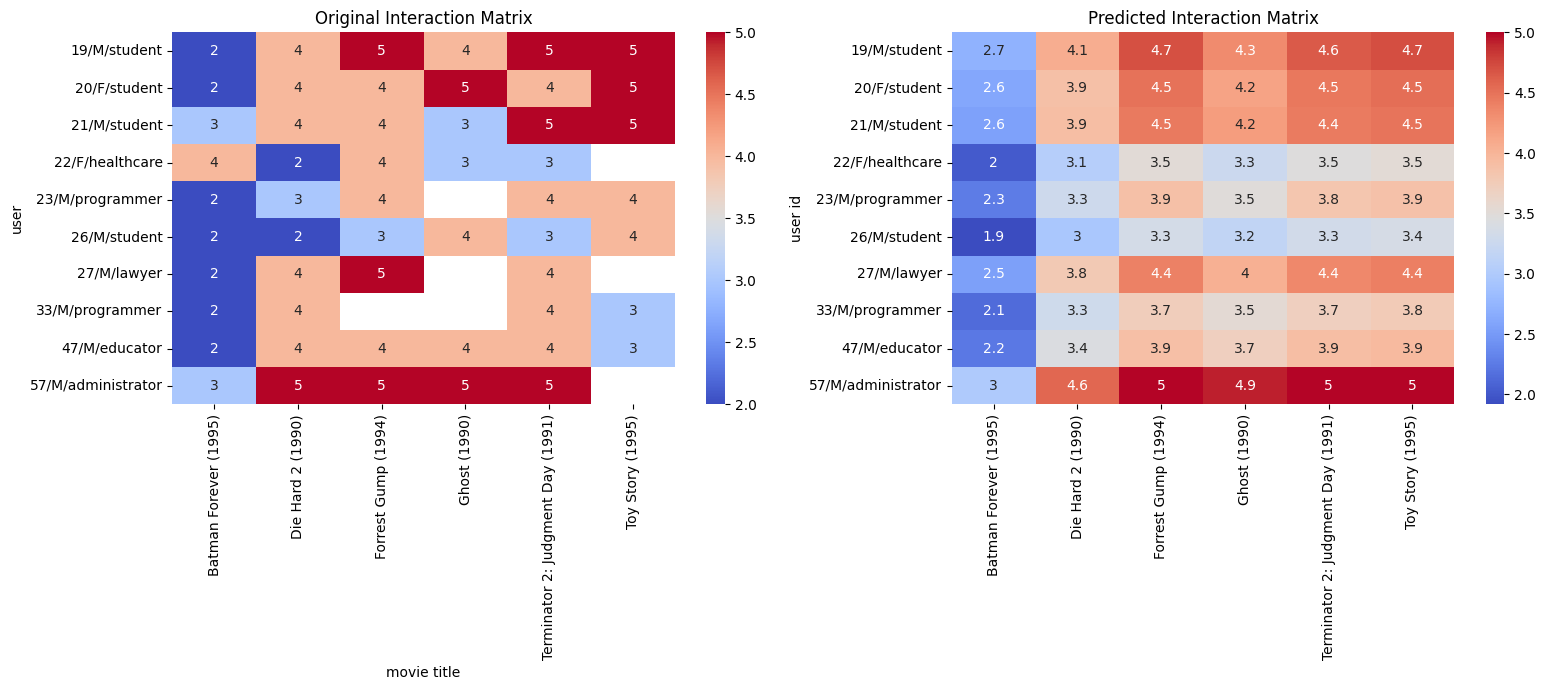

In [36]:
# 원래 상호작용행렬과 예측한 상호작용행렬을 Heat을 사용하여 표시합니다.
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(
    df_interaction,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[0]
)
axes[0].set_title('Original Interaction Matrix')

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True, cmap=cmap_coolwarm,
    ax=axes[1]
)
axes[1].set_title('Predicted Interaction Matrix')

plt.tight_layout()
plt.show()

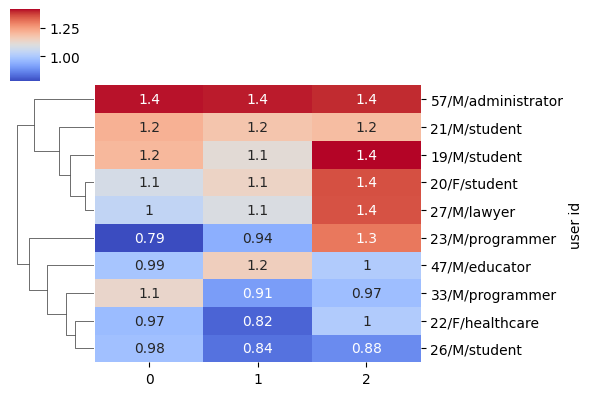

In [37]:
sns.clustermap(
    df_user_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(6,4),
)
plt.show()

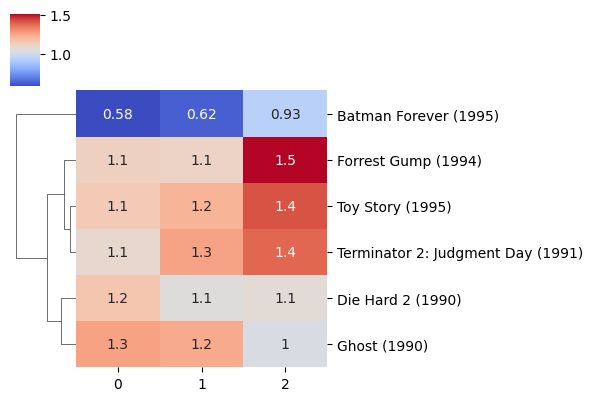

In [38]:
sns.clustermap(
    df_item_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(6, 4),
)
plt.show()

## Tensorflow로 MovieLens100K 학습하기

$\hat{r}_{ui} = \bar{r} + \bar{r_u} + \bar{r_i} + ue_u \cdot ie_i$

$\bar{r_u}$: 사용자의 상대적 평균(다른 사용자에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

$\bar{r_i}$: 아이템의 상대적 평균(다른 아이템에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

ue: User Embedding, ie: Item Embedding

In [39]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

In [40]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [41]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ratings, train_size=0.8, random_state=123, shuffle=True)

In [42]:
df_train['user id'].value_counts()

user id
405    593
655    537
13     489
450    443
276    423
      ... 
876     14
812     14
685     14
147     14
866     13
Name: count, Length: 943, dtype: int64

In [43]:
ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_test = tf.data.Dataset.from_tensor_slices(
    ({i: df_test[i] for i in ['item id', 'user id']}, df_test['rating'])
)

In [44]:
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'item id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'user id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>} tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


**Matrix Factorization**

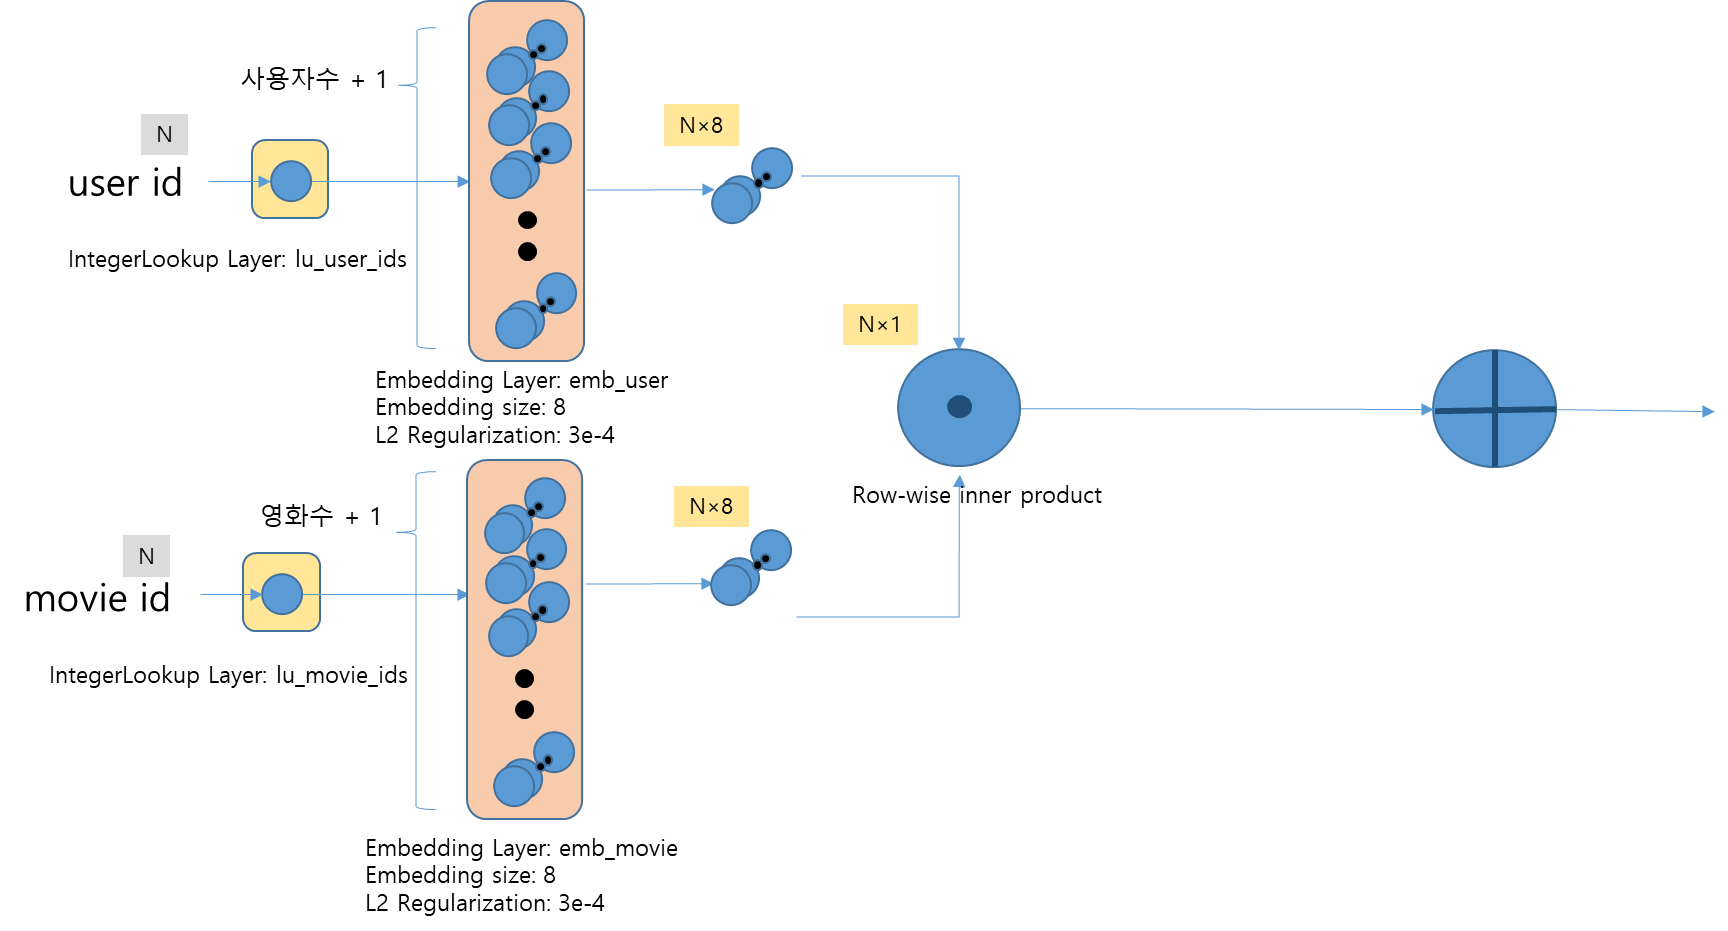

In [44]:
# 모델에서 사용하는 요소들을 Eager Execution 모드에서 제작합니다.
# 모델을 만드는 게 훨씬 수월해집니다.

# user id를 위치 Index로 바꿔주는 레이어입니다. 
lu_userid = tf.keras.layers.IntegerLookup(
    vocabulary=tf.constant(df_train['user id'].unique())
)
# 사용자 임베딩 레이어입니다.
emb_user = tf.keras.layers.Embedding(
    df_train['user id'].nunique() + 1, 8
)

# item id를 위치 Index로 바꿔주는 레이어입니다. 
lu_movieid = tf.keras.layers.IntegerLookup(
    vocabulary=tf.constant(df_train['item id'].unique())
)
# 아이템 임베딩 레이어입니다.
emb_movie = tf.keras.layers.Embedding(
    df_train['item id'].nunique() + 1, 8
)

# Row-wise (axes=-1) Dot Product 레이어입니다.
dot = tf.keras.layers.Dot(axes=-1)

# user id를 임베딩에서의 위치 인덱스로 가져옵니다.
uid = lu_userid(tf.constant([1, 2, 0, -1, 5]))
# item id를 임베딩에서의 위치 인덱스로 가져옵니다.
mid = lu_movieid(tf.constant([3, 4, 5, 6, 7]))
# 위치 인덱스에 해당하는 사용자 임베딩을 가져옵니다.
x_uid = emb_user(uid)
# 위치 인덱스에 해당하는 영화 임베딩을 가져옵니다.
x_mid = emb_movie(mid)

# 결과를 출력합니다.
x_uid, x_mid, dot([x_uid, x_mid])

(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[ 0.00447007,  0.00758015, -0.02958552,  0.02205514,  0.01321752,
          0.04517401,  0.02431544, -0.03519408],
        [-0.00095763, -0.02279965, -0.02313825, -0.01387329,  0.04702956,
         -0.04658431,  0.04689175, -0.00610126],
        [ 0.03516607,  0.02809909, -0.01476068, -0.02530549,  0.00896212,
          0.03690279, -0.04034451, -0.02863151],
        [ 0.03516607,  0.02809909, -0.01476068, -0.02530549,  0.00896212,
          0.03690279, -0.04034451, -0.02863151],
        [-0.01070993, -0.01637026,  0.01585415,  0.01534473,  0.00176641,
          0.00327205, -0.04228901, -0.04229442]], dtype=float32)>,
 <tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[-0.04565717, -0.01195757, -0.01619411, -0.02092569,  0.04208931,
          0.02990759,  0.00457378,  0.01309163],
        [ 0.04338017, -0.01052551, -0.03209227,  0.035392  , -0.00773241,
         -0.00108556, -0.0197564 , -0.02530352],
        [ 0.04653386, -

**Mean Model**

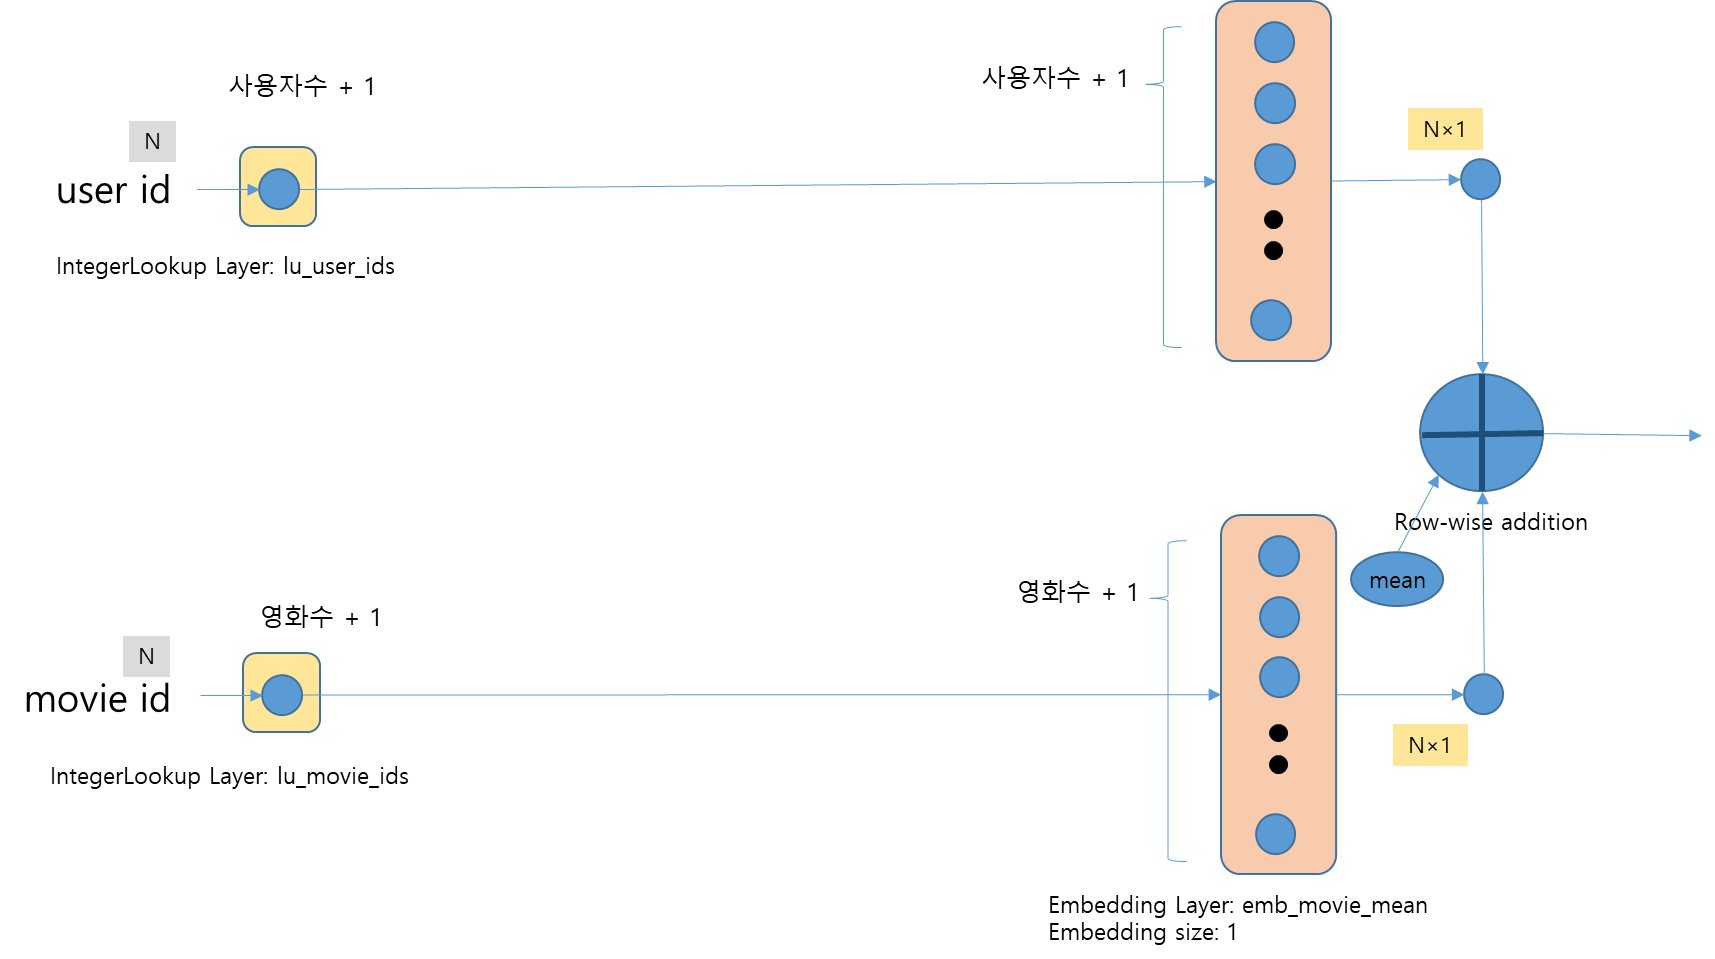

In [45]:
# 전체 평균을 구합니다.
mean = tf.constant([df_train['rating'].mean()], dtype=tf.float32)
lu_userid = tf.keras.layers.IntegerLookup(
    vocabulary=tf.constant(df_train['user id'].unique())
)
# 사용자의 평균을 저장하는 임베딩입니다.
emb_user_mean = tf.keras.layers.Embedding(
    df_train['user id'].nunique() + 1, 1
)

lu_movieid = tf.keras.layers.IntegerLookup(
    vocabulary=tf.constant(df_train['item id'].unique())
)
# 영화의 평균을 저장하는 임베딩입니다.
emb_movie_mean = tf.keras.layers.Embedding(
    df_train['item id'].nunique() + 1, 1
)

uid = lu_userid(tf.constant([1, 2, 0, 1, 5]))
mid = lu_movieid(tf.constant([3, 4, 5, 6, 7]))

x_uid = emb_user_mean(uid)
x_mid = emb_movie_mean(mid)

x_uid, x_mid, x_uid + x_mid + mean

(<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 0.03264097],
        [ 0.02636759],
        [-0.00640482],
        [ 0.03264097],
        [ 0.03920806]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[-0.04544263],
        [ 0.03200286],
        [ 0.02156467],
        [-0.04319593],
        [-0.02900295]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[3.5170608],
        [3.5882328],
        [3.5450222],
        [3.5193074],
        [3.5400674]], dtype=float32)>)

**Matrix Factorization augumented user/item mean Model Architecture**

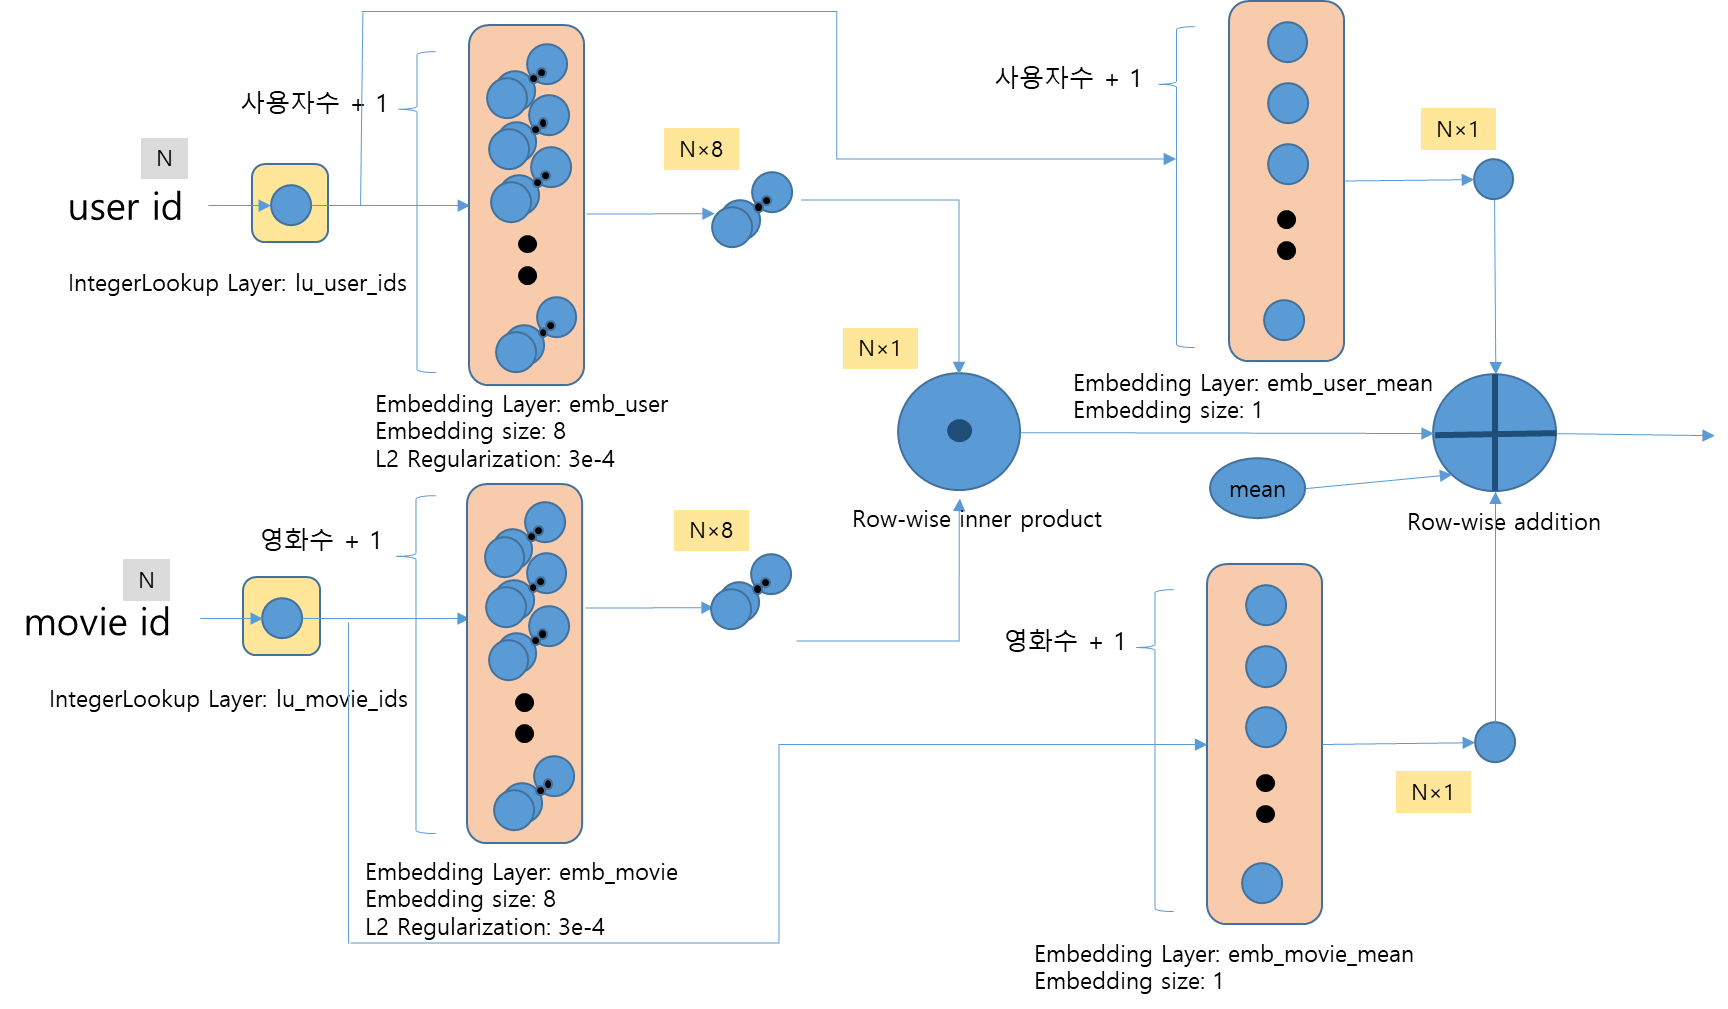

In [95]:
class MF_Mean_Model(tf.keras.Model):
    def __init__(self, user_ids, item_ids, rank):
        super().__init__()
        # user id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_user = # TODO with
        # item id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_item = # TODO with
        
        # user id에 대한 상대적 평균을 나타내는 임베딩입니다.
        self.emb_user_mean = # TODO with
        # item id에 대한 상대적 평균을 나타내는 임베딩입니다. 
        self.emb_item_mean = # TODO with
        
        # 사용자 행렬을 나타내는 사용자 임베딩입니다. embedding_regularizer L2=3e-4를 두어 Overfitting을 방지합니다.
        self.emb_user = # TODO with
        # 사용자 행렬을 나타내는 사용자 임베딩입니다. embedding_regularizer L2=3e-4를 두어 Overfitting을 방지합니다.
        self.emb_item = # TODO with
        
        # 맵핑된 사용자 임베딩과 맵핑된 아이템 임베딩을 Row-wise inner product 연산을 해주는 layer입니다. 
        self.dot = tf.keras.layers.Dot(axes=-1)
        
    def call(self, x, training=False):
        x_user = # TODO with # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] N×1 정수 / x_user: N×1 정수
        user_vec = # TODO with # 사용자 임베딩을 가져옵니다. user_vec: N×rank 실수
        user_mean = # TODO with # 사용자의 상대적 평균을 가져옵니다. user_mean: N×1 실수
        
        x_item = # TODO with # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N×1 정수 / x_movie: N×1 정수
        item_vec = # TODO with # 아이템 임베딩을 가져옵니다. user_vec: N×rank 실수
        item_mean = # TODO with # 아이템의 상대적 평균을 가져옵니다.
        
        return user_mean + item_mean + self.dot([user_vec, item_vec])
    
    def predict_by_userid(self, user_id, item_ids):
        """
            한명의 사용자에게 여러 개의 아이템의 평점을 예측합니다.
        """
        x_user = self.lu_user([user_id]) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] (1) / x_user (1)
        user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. emb_user: 1×rank개의 실수
        x_item = self.lu_item(item_ids) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N개의 정수 / x_item: N개의 정수
        item_vec = self.emb_item(x_item)
        return tf.squeeze(
            tf.matmul(item_vec, user_vec, transpose_b=True) + 
            self.emb_item_mean(x_item) +
            self.emb_user_mean(x_user)
        )

In [97]:
mf_mean_model = MF_Mean_Model(
    df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), # train에서 20회 넘게 등장한 사용자 ID를 전달합니다. 
    df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), # train에서 20회 넘게 등장한 아이템 ID를 전달합니다.
    8
)

In [88]:
tf.keras.backend.clear_session()
mf_mean_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), # Adam Optimizer를 사용합니다.
    loss=tf.keras.losses.MeanSquaredError(), # 손실은 MSE를 사용합니다.
    metrics=tf.keras.metrics.MeanSquaredError() # 지표는 MSE로 합니다.
)

In [89]:
mf_mean_model.fit(ds_train.shuffle(100000).batch(256), validation_data=ds_test.batch(256), epochs=20)

Epoch 1/20
313/313 [==============================] - 6s 18ms/step - loss: 8.3345 - mean_squared_error: 8.1172 - val_loss: 2.9630 - val_mean_squared_error: 2.2960
Epoch 2/20
313/313 [==============================] - 2s 6ms/step - loss: 2.3434 - mean_squared_error: 1.4609 - val_loss: 2.1272 - val_mean_squared_error: 1.1454
Epoch 3/20
313/313 [==============================] - 2s 6ms/step - loss: 2.0592 - mean_squared_error: 1.0616 - val_loss: 2.0378 - val_mean_squared_error: 1.0425
Epoch 4/20
313/313 [==============================] - 2s 5ms/step - loss: 1.9796 - mean_squared_error: 1.0040 - val_loss: 1.9689 - val_mean_squared_error: 1.0196
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 1.9045 - mean_squared_error: 0.9861 - val_loss: 1.8907 - val_mean_squared_error: 1.0030
Epoch 6/20
313/313 [==============================] - 2s 6ms/step - loss: 1.8241 - mean_squared_error: 0.9734 - val_loss: 1.8111 - val_mean_squared_error: 0.9991
Epoch 7/20
313/313 [=======

In [90]:
# 영화 임베딩을 3차원 공간에 투영하여 학습된 임베딩의 특성을 확인해봅니다.
import os

log_dir='logs/m100k/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# TSV로 만들면 영화 타이트을 투영시 보이게 할 수 있습니다.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index:
        f.write("{}\n".format(df_movie.loc[i, 'movie title']))

# 영화의 임베딩을 기록합니다.
weights =  tf.Variable(mf_mean_model.emb_item.get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [91]:
%tensorboard --logdir logs/m100k/ --bind_all

In [99]:
# 1번 사용자에 대해 영화 번호 [1, 2, 3]에 대한 예측을 해봅니다.
mf_mean_model.predict_by_userid(1, [1, 2, 3])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.07840887, -0.04873322, -0.0532316 ], dtype=float32)>

## NNModel

**Neural Networks Architecture**

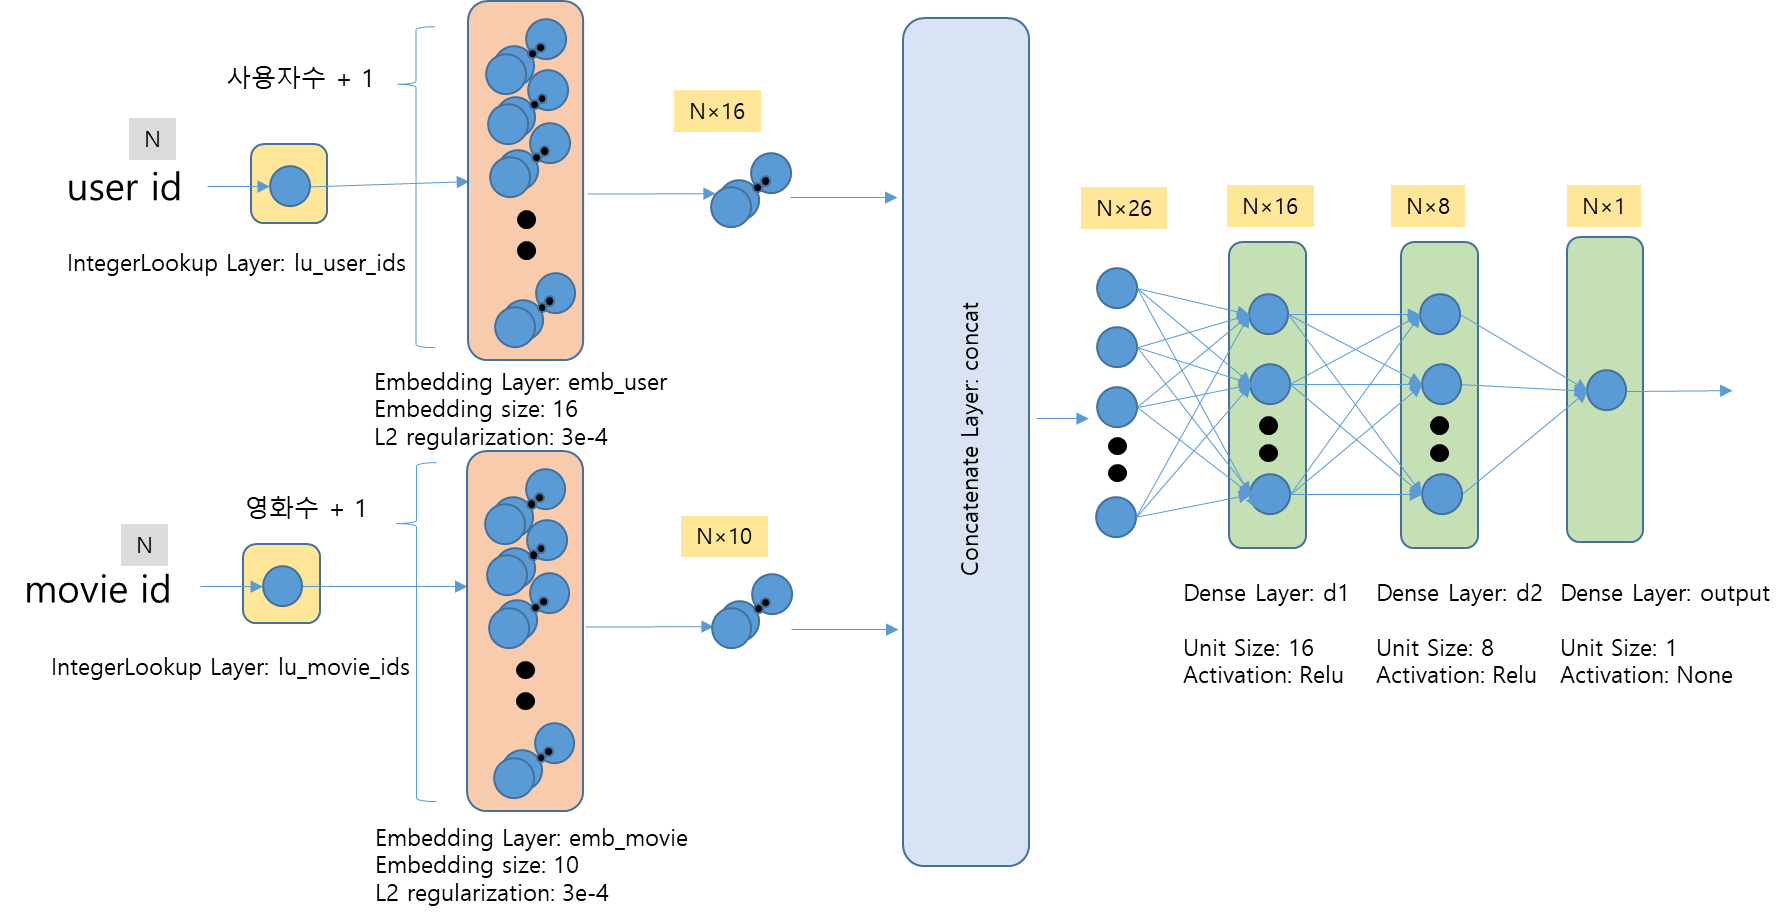

In [100]:
class NNModel(tf.keras.Model):
    def __init__(self, user_ids, item_ids, emb_user_size, emb_item_size):
        super().__init__()
        self.lu_user = tf.keras.layers.IntegerLookup(vocabulary=user_ids)
        self.lu_item = tf.keras.layers.IntegerLookup(vocabulary=item_ids)
        
        self.emb_user =  tf.keras.layers.Embedding(
            len(user_ids) + 1, emb_user_size, embeddings_regularizer=tf.keras.regularizers.L2(3e-4)
        )
        self.emb_item =  tf.keras.layers.Embedding(
            len(item_ids) + 1, emb_item_size, embeddings_regularizer=tf.keras.regularizers.L2(3e-4)
        )
        
        self.cc = tf.keras.layers.Concatenate(axis=-1)
        
        self.dl1 = tf.keras.layers.Dense(16, activation='relu')
        self.dl2 = tf.keras.layers.Dense(8, activation='relu')
        self.o = tf.keras.layers.Dense(1)
    def call(self, x, training=False):
        x_user = self.lu_user(x['user id'])
        x_user = self.emb_user(x_user)
        x_item = self.lu_item(x['item id'])
        x_item = self.emb_item(x_item)
        y = self.cc([x_user, x_item])
        y = self.dl1(y)
        y = self.dl2(y)
        return self.o(y)

In [101]:
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'item id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'user id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>} tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


In [105]:
nn_model = NNModel(
    df_train['user id'].pipe(lambda x: x.loc[x > 20]).index.tolist(), 
    df_train['item id'].pipe(lambda x: x.loc[x > 20]).index.tolist(), 16, 10)

In [106]:
tf.keras.backend.clear_session()
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.MeanSquaredError()
)
nn_model.fit(ds_train.shuffle(10000).batch(256), validation_data=ds_test.batch(1024), epochs=20)

Epoch 1/20
313/313 [==============================] - 23s 69ms/step - loss: 5.2972 - mean_squared_error: 5.2482 - val_loss: 1.1216 - val_mean_squared_error: 1.0740
Epoch 2/20
313/313 [==============================] - 21s 68ms/step - loss: 1.0422 - mean_squared_error: 0.9920 - val_loss: 1.0503 - val_mean_squared_error: 0.9990
Epoch 3/20
313/313 [==============================] - 21s 68ms/step - loss: 1.0121 - mean_squared_error: 0.9611 - val_loss: 1.0441 - val_mean_squared_error: 0.9938
Epoch 4/20
313/313 [==============================] - 21s 68ms/step - loss: 1.0062 - mean_squared_error: 0.9569 - val_loss: 1.0429 - val_mean_squared_error: 0.9947
Epoch 5/20
313/313 [==============================] - 21s 68ms/step - loss: 1.0021 - mean_squared_error: 0.9551 - val_loss: 1.0380 - val_mean_squared_error: 0.9924
Epoch 6/20
313/313 [==============================] - 21s 68ms/step - loss: 0.9999 - mean_squared_error: 0.9555 - val_loss: 1.0377 - val_mean_squared_error: 0.9945
Epoch 7/20
313/3

**VS Neural Network**

**Matrix Factorization**: 사용자 한 명의 영화에 대한 예측은 한 번의 모델 실행으로 구할 수 있습니다.

따라서, Matrix Factorization은 Neural Network 보다 서비스 시 더 빠릅니다.

※ Google에서 개발한 ScaNN과 같은 알고리즘 이 과정을 보다 최적화시켜 줍니다.

하지만, Matrix는 사용자와 아이템을 동일한 사이즈(Rank)로 구성해야 하는 구조적 제약을 가지고 있어

Neural Network에 비해 제약적인 구성을 가지고 있습니다. 

이로 인해 정교한 모델링이 Neural Network보다 어렵습니다.

이 둘을 활용하는 전략에 대해 아래 논문이 자세히 다루고 있습니다.

[Youtube Recommender](https://github.com/Dryjelly/Youtube_Recommendation_tf_keras)

논문의 골자: 

Matrix Factorization은 추천 아이템을 1차적으로 후보 대상을 선정하여 예측 대상을 줄이고,

Nerual Network을 통해 정교한 예측 결과로 순위를 메기는 구조로

추천 시스템을 구성한다는 것입니다.

In [110]:
%%timeit
mf_mean_model.predict_by_userid(1,  tf.constant(df_movie.index))

2.83 ms ± 62.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Neural Network**: 사용자 한 명의 영화에 대한 예측을 구하려면 예측할 영화의 개수 만큼 모델을 실행해야 합니다.

In [111]:
%%timeit
X = tf.data.Dataset.from_tensor_slices({
    'user id': [1] * len(df_movie),
    'item id': df_movie.index.values
}).batch(2048)

nn_model.predict(X, verbose=0)

16.5 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


* 하지만 구조상 User와 Item 을 동일한 수의 임베딩으로 모델링해야 한다는 구조적 제약이 있어 Neural Network 보다는 모델 유연한 구성이 힘듭니다

# 문제점

Matrix Factorization 모델 뿐만 아니라, 데이터 기반의 방법에서의 문제점이기도 합니다.

## 1. Cold Start Problem

데이터가 확보되지 않은 사용자나 아이템에 대한 예측의 정확도가 떨어집니다.

In [112]:
# 시점을 기준으로 나누어 Test에는 Train에 등장하지 않은 사용자와 영화가 배치되도록 합니다.
df_train = df_ratings.query('date < "1998-03-01"')
df_test = df_ratings.query('date >= "1998-03-01"')

ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_test = tf.data.Dataset.from_tensor_slices(
    ({i: df_test[i] for i in ['item id', 'user id']}, df_test['rating'])
)

In [113]:
# Train에 등장하지 않은 사용자의 출연 빈도를 봅니다.
df_test['user id'].value_counts().pipe(lambda x: x.loc[~x.isin(df_train['user id'].unique())])

user id
234    480
796    358
551    334
334    333
393    234
      ... 
661      3
577      3
561      3
483      3
453      3
Name: count, Length: 75, dtype: int64

In [115]:
mf_mean_model = MF_Mean_Model(df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), 
                   df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), 16)
tf.keras.backend.clear_session()
mf_mean_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.MeanSquaredError()
)

In [116]:
mf_mean_model.fit(ds_train.shuffle(100000).batch(256), validation_data=ds_test.batch(1024), epochs=20)

Epoch 1/20
305/305 [==============================] - 8s 24ms/step - loss: 6.4226 - mean_squared_error: 5.9879 - val_loss: 2.2396 - val_mean_squared_error: 1.2903
Epoch 2/20
305/305 [==============================] - 2s 7ms/step - loss: 2.0686 - mean_squared_error: 1.0730 - val_loss: 2.1687 - val_mean_squared_error: 1.1693
Epoch 3/20
305/305 [==============================] - 2s 6ms/step - loss: 1.9676 - mean_squared_error: 0.9993 - val_loss: 2.0603 - val_mean_squared_error: 1.1253
Epoch 4/20
305/305 [==============================] - 2s 7ms/step - loss: 1.8705 - mean_squared_error: 0.9783 - val_loss: 1.9797 - val_mean_squared_error: 1.1361
Epoch 5/20
305/305 [==============================] - 2s 7ms/step - loss: 1.7683 - mean_squared_error: 0.9665 - val_loss: 1.8721 - val_mean_squared_error: 1.1132
Epoch 6/20
305/305 [==============================] - 2s 5ms/step - loss: 1.6591 - mean_squared_error: 0.9486 - val_loss: 1.7694 - val_mean_squared_error: 1.1067
Epoch 7/20
305/305 [=======

In [118]:
s_mse = df_test.assign(
    rating_hat = np.squeeze(mf_mean_model.predict(ds_test.batch(1024)))
).groupby('user id').apply(lambda x: mean_squared_error(x['rating'], x['rating_hat'])).rename('mse')

22/22 [==============================] - 0s 2ms/step


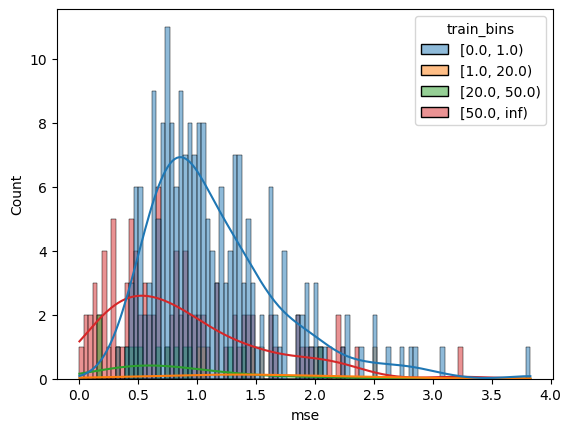

In [119]:
pd.concat([
    df_train['user id'].value_counts().rename('train count'),
    df_test['user id'].value_counts().rename('test count'), s_mse
], axis=1).pipe(lambda x: x.loc[x['test count'].notna()]).fillna(0)\
.assign(
    train_bins = lambda x: pd.cut(x['train count'], bins=[0, 1, 20, 50, np.inf], right=False)
).pipe(lambda x: sns.histplot(data=x, x='mse', hue='train_bins', bins=100, kde=True))
plt.show()

## 2. 지속적인 재학습 필요

사용자, 아이템이 추가될 때마다, 모델을 재구성해줘야 하고

새로운 데이터로 재학습을 시켜줘야합니다.

이후 챕터에서는 이를 극복하기 위한 방법을 소개드립니다.